# Importing and Initializing

We need to import the `BTree` class that is located in file `btree.py`. Note that when we import we don't put the `.py` extension.

To call the constructor of the `BTree` method we need to use the `super()` function.

To simplify testing, we will always build the `BTree` using a `split_threshold` equal to `2`.

In [1]:
from btree import BTree

In [2]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)

# Overriding the Add Method

To override a method from the superclass we need to declare a method with the same name as the one we are overriding. 

We override the `add()` method because we want a different behavior in the `KVStore` than the one inherited from the `BTree`. Namely, we want to have no duplicates.

To implement the new `add()` method we will need to use the `BTree._find_node()` and `BTree.add()` methods.

In [3]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value

# Testing

Let's test the current implementation. We want to make sure that:

1. The split threshold is correct.
2. We can add entries.
3. We can retrieve a value given a key.
4. If we add two entries with the same key, the value is updated.

In [4]:
kv = KVStore()

# Check the split threshold
assert kv.split_threshold == 2, "Split threshold is 2"

# Add the entries (i, i) for i from 0 to 9
for i in range(10):
    kv.add(i, i)

# Check the values
for i in range(10):
    assert kv.get_value(i) == i, "Value of i is i"

# Add again with different values
for i in range(10):
    kv.add(i, i + 1)

# Check the new values
for i in range(10):
    assert kv.get_value(i) == i + 1, "Value of i is i + 1"

# Implementing the Item Getter and Setter

To allow users to use the bracket notation, we need to implement the `__getitem__()` and `__setitem__()` methods.

These methods are already implement but are named `get_value()` and `add()`, respectively. We can thus implement them by calling the corresponding method.

In [5]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)

# Testing Getter and Setter

Let's redo the same tests but using bracket syntax.

In [6]:
kv = KVStore()

# Check the split threshold
assert kv.split_threshold == 2, "Split threshold is 2"

# Add the entries (i, i) for i from 0 to 9
for i in range(10):
    kv[i] = i

# Check the values
for i in range(10):
    assert kv[i] == i, "Value of i is i"

# Add again with different values
for i in range(10):
    kv[i] = i + 1

# Check the new values
for i in range(10):
    assert kv[i] == i + 1, "Value of i is i + 1"

# Enhancing the Contains Method

To enable the `in` operator, we need wrap the `BTree.contains()` method inside a new method named `__contains__()`.

In [7]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)

    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __contains__(self, key):
        return self.contains(key)

# Testing the In Operator

Let's do a test to see if we can use the `in` operator. We'll use alphabet letters as keys to see if other kind of keys are supported.

In [8]:
kv = KVStore()
for c in 'abcdefghijklmnopqrstuvwxyz':
    kv[c] = c

for c in 'abcdefghijklmnopqrstuvwxyz':
    assert c in kv, "Character is in the key-value store"

# Range Queries

Our solution consisted in replacing both `float('-inf')` and `float('inf')` by `None`. Then we created a method named `_range_intersects` that checks whether the query range intersects with the node range.

We make the condition work in a way such that if `min_key` is `None` then it is always considered smaller than any other key and if `max_key` is `None` then it is always considered larger than any other key.

In [9]:
class KVStore(BTree):
    
    def __init__(self):
        super().__init__(split_threshold=2)
        
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            # Replace the old value by the new
            for i, node_key in enumerate(node.keys):
                if node_key == key:
                    node.values[i] = value
                    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __getitem__(self, key):
        return self.get_value(key)

    def __contains__(self, key):
        return self.contains(key)
    
    def _range_query(self, range_start, range_end, current_node, min_key, max_key):
        if not self._range_intersects(range_start, range_end, min_key, max_key):
            return []
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
        if not current_node.is_leaf():
            for i, child in enumerate(current_node.children):
                new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                new_max_key = current_node.keys[i] if i < len(current_node) else max_key
                results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
        return results 

    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, float('-inf'), float('inf'))
    
    def _range_intersects(self, range_start, range_end, node_min, node_max):
        if not node_min is None and node_min > range_end:
            return False
        if not node_max is None and node_max < range_start:
            return False
        return True

In [10]:
class DictKVStore(dict):
    
    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result

# Test range query

Test the range against the dictionary range query.

In [11]:
dict_kv = DictKVStore()
our_kv = KVStore()
for i in range(10):
    dict_kv[i] = i
    our_kv[i] = i

for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, "Both data structures return the same range query result."

# Random Tests

In [12]:
import random
random.seed(0)

NUM_INSERTS = 10
NUM_CONTAINS = 10
NUM_RANGE_QUERIES = 10

dict_kv = DictKVStore()

kv = KVStore()

print("Testing Insertion")
for _ in range(NUM_INSERTS):
    key = random.randint(0, 100)
    value = random.randint(0, 1000000)
    dict_kv[key] = value
    kv[key] = value
    
print("Testing Length")
assert len(dict_kv) == len(kv), "Wrong length. Length should be {} but is {}.".format(len(dict_kv), len(kv))
    

print("Testing Values")
for key in dict_kv:
    assert dict_kv[key] == kv[key], "Wrong value for key {}. Expected value {} but found value {}.".format(key, dict_kv[key], kv[key])

    
print("Testing in Operator")
for i in range(NUM_CONTAINS):
    key = random.randint(0, 1000)
    assert (key in dict_kv) == (key in kv), "Contains method did not return the correct value for key {}.".format(key)


print("Testing Range Queries")
for _ in range(NUM_RANGE_QUERIES):
    range_start = random.randint(0, 100)
    range_end = random.randint(range_start, 100)
    dict_results = dict_kv.range_query(range_start, range_end)
    kv_results = kv.range_query(range_start, range_end)
    assert len(dict_results) == len(kv_results), "Wrong number of reuslt in range query [{}, {}]. Should be {} but was {}.".format(range_start, range_end, len(dict_result), len(kv_result))
    dict_results.sort()
    kv_results.sort()
    assert dict_results == kv_results, "Wrong number of reuslt in range query [{}, {}]. Should be {} but was {}.".format(range_start, range_end, len(dict_result), len(kv_result))

Testing Insertion
Testing Length
Testing Values
Testing in Operator
Testing Range Queries


# Speed Tests

To perform the speed tests we start by creating an empty data structure of each type.

Then we load all entries from the `entries.csv` file.

After that, loop over each query in the `queries.csv` file. For each query, we measure its execution time on both data structure. Then we compute the execution time ratio between the dictionary solution and our solution.

In the end we plot the result.

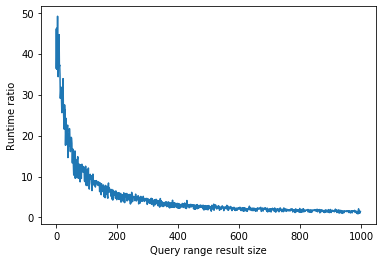

In [14]:
import time
import csv

dict_kv = DictKVStore()
our_kv = KVStore()

# Load the entries
with open('entries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        key = int(row[0])
        value = int(row[1])
        dict_kv[key] = value
        our_kv[key] = value

# Measure query times
time_ratios = []
with open('queries.csv', 'r') as f:
    rows = list(csv.reader(f))[1:]
    for row in rows:
        range_start = int(row[0])
        range_end = int(row[1])
        
        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        time_dict = end - start

        start = time.time()
        our_kv.range_query(range_start, range_end)
        end = time.time()
        time_kv = end - start

        time_ratios.append(time_dict / time_kv)

# Plot results
import matplotlib.pyplot as plt
plt.plot(time_ratios)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()

# Conclusion

For 50,000 entries, we get a performance boost of at most 50 times. 

We see that the performance boost decreases as the size of the of query increases. This is expected since the more result we return the closer we get to having to iterate of all entries in the tree.

With 100,000 entries the performance boost can go up to about 120 times.